In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [9]:
import uuid
str(uuid.uuid1())

'970605d8-d1ad-11ea-915e-ac1f6ba129e2'

In [20]:

from fastai.vision.models import WideResNet

def _wrn_22():
    "Wide ResNet with 22 layers."
    return WideResNet(num_groups=3, N=3, num_classes=10, k=6, drop_p=0.2)

#nn.Sequential(*list(_wrn_22().children()))

nn.Sequential(*list(_wrn_22().children())[0])

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BasicBlock(
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Sequential(
      (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (drop): Dropout(p=0.2, inplace=True)
    (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (2): BasicBlock(
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Sequential(
      (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=

In [2]:
from file_cache import *
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


2020-07-23 18:18:33,341 util_log.py[153] INFO Start the program at:amax7, 127.0.1.1, with:Load module


File_cache: Adjust notebook work fold to:/share/felix/pj/thyroid_seg/


In [3]:
df = pd.read_csv('/home/felix/pj/thyroid_seg/input/TNSCUI2020_train/train.csv')
print(df.shape)
df.head()

(3644, 2)


,ID,CATE
0,5189.PNG,0
1,2090.PNG,1
2,5156.PNG,0
3,8303.PNG,1
4,9650.PNG,1


In [4]:
df.CATE.value_counts()

1    2003
0    1641
Name: CATE, dtype: int64

In [5]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [6]:

from file_cache import *

img_file_list = glob('/home/felix/pj/thyroid_seg/input/TNSCUI2020_train/image/*.PNG', recursive=True)

df = pd.DataFrame({'img_file':img_file_list})

df['label_path'] = df.img_file.apply(lambda val: val.replace('image', 'mask'))
df['sn'] = df.img_file.apply(lambda val: os.path.basename(val).split('.')[0]  ).astype(int)
df = df.sort_values('sn')

np.random.seed(2007)
df['fold'] = np.random.randint(0, 5, len(df))
df['valid'] = df.fold ==4
#df['valid'] = df.sn%5 >=4
df.head()

df['size1'] = df.label_path.apply(lambda val: cv2.imread(val).shape[0])
df['size2'] = df.label_path.apply(lambda val: cv2.imread(val).shape[1])
df.sort_values('size1')

codes = list(range(2))
print('codes', list(codes) )


src = (SegmentationItemList.from_df(df, path='/', cols='img_file' )
       .split_from_df(col='valid')
       .label_from_df(cols='label_path', classes=codes)
      )

codes [0, 1]


In [7]:
np.unique(cv2.imread(df.iloc[0,1]), return_counts=True)

(array([0, 1], dtype=uint8), array([866472,   6438]))

In [8]:
# for file in df.label_path:
#     #print(file)
#     img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
#     #print(img.shape)
#     cv2.imwrite(file, img/max(1, img.max()) )

## Datasets

In [9]:
size =224
bs = 4
print('size, bs', size, bs)

size, bs 224 4


In [10]:
 
    
print(len(src.train), len(src.valid), codes)

#get_transforms()
data = (src.transform(None, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

2887 757 [0, 1]


In [11]:
test_data = ImageList.from_folder(path="/share/data2/body/thyroid/test/image")
data.add_test(test_data, tfm_y=False)

In [12]:
# tmp = df.groupby(['p_id', 'valid'], as_index=False).label_path.count()
# tmp.pivot_table(index='p_id', columns='valid', values='label_path').sort_values(0)

In [13]:
for a, b in data.dl(DatasetType.Train):
    break
    
a.shape

torch.Size([4, 3, 224, 224])

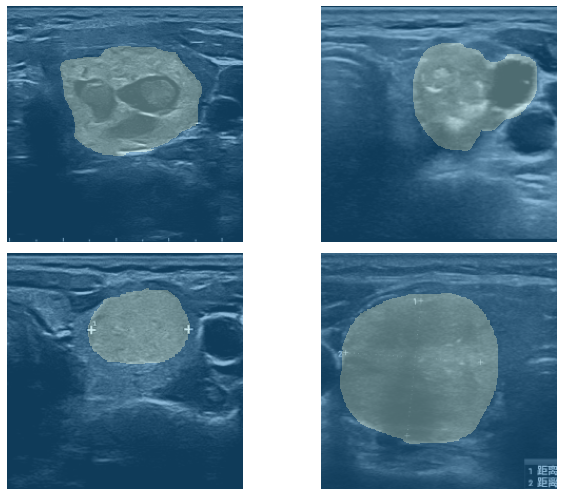

In [14]:
data.show_batch(8, figsize=(10, 7))

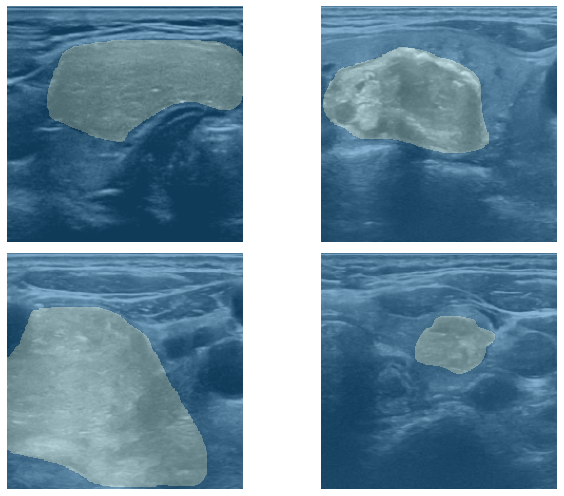

In [15]:
data.show_batch(4, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
#void_code = name2id['Void']

# def acc_camvid(input, target):
#     target = target.squeeze(1)
#     mask = target != void_code
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [17]:
wd = 1e-2


In [18]:
print('abc', data.c)

abc 2


In [19]:

def dice_multiply(logits, targets, cls_id=None):
    batch_size, class_cnt = logits.shape[0], logits.shape[1]

    dice_list = []
    for class_index in range(class_cnt):
        predict = logits.argmax(axis=1) == class_index
        target = (targets == class_index)

        predict = predict.view(batch_size, -1)
        target = target.view(batch_size, -1)

        # print('======', predict.shape,  target.shape)
        # print(predict.shape, logits.shape, target.shape)
        inter = torch.sum(predict * target, dim=1)
        union = torch.sum(predict, dim=1) + torch.sum(target, dim=1)
        dice = (2. * inter + 1) / (union + 1)
        # print(dice)
        dice = dice.mean()
        # print(dice, inter, union)
        dice_list.append(dice)
    # print(dice_list)
    if cls_id is None:
        return torch.Tensor(dice_list)
    else:
        return torch.Tensor(dice_list)[cls_id]


In [20]:
#多类别的Dice Metrics

#from brain.metrics import * 

from functools import partial
def dice_fn(cls_id):
    fn = partial(dice_multiply, cls_id=cls_id) 
    fn.__name__ = f'dice_{cls_id}'
    return fn
 

metrics = [ dice_fn(i) for i in codes ] #, accuracy,
print('len=', len(metrics))
#import ipdb
# ipdb.set_trace()
# learn = unet_learner(data, models.resnet50, metrics=metrics , wd=wd)

# for sn, child in enumerate(learn.model.children()):
#     print(sn, '===', child)

len= 2


In [21]:
from dynamic_unet.base import *
from efficientnet_pytorch import EfficientNet
eff=3
def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=None, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
                 self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None, eff=eff, **learn_kwargs:Any)->Learner:
    
    
    encoder = efficient_unet(eff)
    unet = DynamicUnet(encoder, n_classes=2, img_size=(224, 224), blur=False, blur_final=False,
                    self_attention=False, y_range=None, norm_type=NormType,
                    last_cross=True,
                    bottle=False)
    
 
    learn = Learner(data, unet, **learn_kwargs)
    return learn

iou =  partial(dice, iou=True)
metrics = [ dice_fn(i) for i in codes ]
metrics = metrics + [dice, iou]
learn = unet_learner(data, unet_learner, metrics=metrics, wd=wd)

Loaded pretrained weights for efficientnet-b3
    sn                 layer     c    w    h               size
4    4           MBConvBlock    24  112  112  (1, 24, 112, 112)
7    7           MBConvBlock    32   56   56    (1, 32, 56, 56)
10  10           MBConvBlock    48   28   28    (1, 48, 28, 28)
20  20           MBConvBlock   136   14   14   (1, 136, 14, 14)
31  31  MemoryEfficientSwish  1536    7    7    (1, 1536, 7, 7)


In [22]:
os.path.abspath('./output/model')

'/share/felix/pj/thyroid_seg/output/model'

In [23]:

learn.model_dir=os.path.abspath('./output/model')
os.makedirs(learn.model_dir, exist_ok=True)
learn.lr_find()

epoch,train_loss,valid_loss,dice_0,dice_1,dice,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


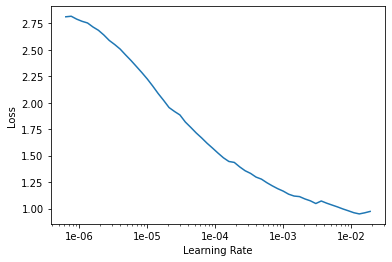

In [24]:
learn.recorder.plot()

In [25]:
print(eff)
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)


3


epoch,train_loss,valid_loss,dice_0,dice_1,dice,dice,time
0,0.191615,0.177401,0.955250,0.368679,0.368188,0.280207,02:35
1,0.141350,0.137375,0.966762,0.589122,0.588846,0.470873,02:36
2,0.098111,0.099810,0.975345,0.724540,0.724376,0.618375,02:37
3,0.080114,0.095429,0.977866,0.752058,0.751903,0.651295,02:42
4,0.058955,0.071794,0.981153,0.799900,0.799739,0.710102,02:37


In [26]:
print(eff)
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

3


epoch,train_loss,valid_loss,dice_0,dice_1,dice,dice,time
0,0.045955,0.077777,0.980951,0.804102,0.803922,0.716222,02:40
1,0.044151,0.075534,0.981357,0.781820,0.781616,0.694464,02:38
2,0.041744,0.071110,0.981824,0.816458,0.816356,0.725574,02:37
3,0.041214,0.093025,0.980570,0.812943,0.812847,0.724283,02:42
4,0.035712,0.079721,0.981928,0.820573,0.820462,0.736763,02:42


# Batch test end

In [27]:
lr = 1e-3
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice,dice,time
0,0.043963,0.119848,0.977677,0.811303,0.811231,0.715041,02:39
1,0.144147,0.124226,0.971079,0.702477,0.702316,0.597234,02:39
2,0.110448,0.103951,0.977047,0.744506,0.744338,0.644777,02:40
3,0.100368,0.104211,0.973480,0.749606,0.749529,0.642715,02:38
4,0.057740,0.075058,0.981102,0.812915,0.812792,0.720989,02:41


In [28]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice,dice,time
0,0.055761,0.069527,0.981652,0.818355,0.818225,0.727091,02:36
1,0.047944,0.068012,0.982249,0.827721,0.827563,0.738256,02:41
2,0.044383,0.072259,0.982200,0.829959,0.829874,0.743240,02:40
3,0.042466,0.069640,0.982591,0.840719,0.840644,0.754522,02:40
4,0.038556,0.069096,0.983037,0.842515,0.842440,0.758058,02:39


In [29]:
lr = 1e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice,dice,time
0,0.035994,0.071025,0.983074,0.842592,0.842512,0.758042,02:40
1,0.034827,0.070354,0.983265,0.844242,0.844164,0.759770,02:39
2,0.032389,0.074506,0.983325,0.844403,0.844328,0.759402,02:41
3,0.036528,0.069018,0.983273,0.842563,0.842479,0.757123,02:39
4,0.029458,0.080430,0.983080,0.843652,0.843578,0.758707,02:41
5,0.030676,0.094251,0.982268,0.843652,0.843578,0.758300,02:41
6,0.027810,0.084443,0.983294,0.846517,0.846433,0.762462,02:40
7,0.030198,0.079692,0.983354,0.845706,0.845632,0.760404,02:41
8,0.026504,0.089685,0.982855,0.847393,0.847326,0.762513,02:39
9,0.026436,0.097161,0.983030,0.848058,0.847991,0.764185,02:38


In [32]:
lr = 1e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice,dice,time
0,0.023633,0.106049,0.983405,0.848555,0.848482,0.763188,02:32
1,0.023886,0.090182,0.983568,0.849754,0.849693,0.765055,02:36
2,0.026762,0.102174,0.981599,0.836613,0.836503,0.751244,02:36
3,0.032576,0.124514,0.980250,0.822022,0.821876,0.734677,02:39
4,0.050947,0.087024,0.981203,0.826784,0.826710,0.735448,02:37
5,0.062606,0.167773,0.958053,0.653873,0.653740,0.565053,02:37
6,0.060200,0.089434,0.978558,0.806911,0.806834,0.713472,02:38
7,0.054994,0.142102,0.977337,0.791963,0.791881,0.698325,02:39
8,0.064382,0.114899,0.977149,0.786951,0.786835,0.695761,02:39
9,0.036854,0.067049,0.983424,0.838046,0.837948,0.754364,02:37


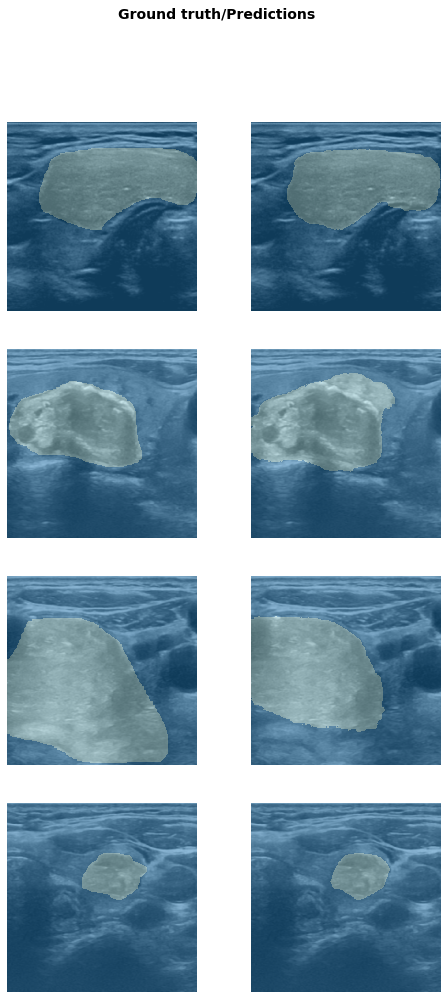

In [33]:
learn.show_results(DatasetType.Valid, rows=40)


In [46]:
a, b = learn.get_preds(DatasetType.Test)

In [47]:
a.shape, b.shape

(torch.Size([910, 2, 224, 224]), torch.Size([910]))

In [48]:
np.unique(b)

array([0])

In [43]:
res[0][0].cpu().numpy()

array([[[1.      , 1.      , 1.      , 1.      , ..., 1.      , 1.      , 1.      , 0.999997],
        [1.      , 1.      , 1.      , 1.      , ..., 1.      , 1.      , 1.      , 1.      ],
        [1.      , 1.      , 1.      , 1.      , ..., 1.      , 1.      , 1.      , 1.      ],
        [1.      , 1.      , 1.      , 1.      , ..., 1.      , 1.      , 1.      , 1.      ],
        ...,
        [1.      , 1.      , 1.      , 1.      , ..., 1.      , 1.      , 1.      , 1.      ],
        [1.      , 1.      , 1.      , 1.      , ..., 1.      , 1.      , 1.      , 1.      ],
        [1.      , 1.      , 1.      , 1.      , ..., 1.      , 1.      , 1.      , 1.      ],
        [1.      , 1.      , 1.      , 1.      , ..., 1.      , 1.      , 1.      , 1.      ]],

       [[0.      , 0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      , 0.000003],
        [0.      , 0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.    

In [53]:
partial(dice, iou=True).__name__

TypeError: dice() missing 2 required positional arguments: 'input' and 'targs'

In [51]:
dice.__name__

'dice'